# Trend Classification Model (LSTM)
*Author: Zuzanna Staśkowiak

In [476]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load your original dataset with labels
data_path = "/kaggle/input/trends/classified_trends_data.xlsx"
data = pd.read_excel(data_path)

# Tworzymy pusty DataFrame na uporządkowane dane


In [477]:
processed_data = pd.DataFrame()
for col in data.columns:
    temp_df = data[col].str.split(',', expand=True)
    temp_df.columns = ['Date', col]
    if 'Date' not in processed_data.columns:
        processed_data['Date'] = temp_df['Date']
    processed_data[col] = pd.to_numeric(temp_df[col], errors='coerce')

processed_data = processed_data.dropna()
processed_data = processed_data.drop(columns=['Date'], errors='ignore')


print(processed_data.head())
kk

   trend  trend.1  trend.2  trend.3  trend.4  no trend  micro trend  \
0   55.0     55.0     48.0     84.0     83.0      28.0        100.0   
1   49.0     53.0     44.0    100.0     99.0      27.0         99.0   
2   18.0     50.0     60.0     79.0     67.0      22.0         51.0   
3   57.0     52.0     50.0     76.0     65.0      28.0         38.0   
4   58.0     65.0     59.0     74.0     61.0      35.0         39.0   

   micro trend.1  micro trend.2  trend.5  ...  micro trend.18  trend.18  \
0           86.0            6.0     49.0  ...               6        46   
1          100.0            6.0     45.0  ...               5        46   
2           84.0            6.0     45.0  ...               4        45   
3           54.0            6.0     50.0  ...               3        46   
4           48.0            6.0     45.0  ...               0        74   

   micro trend.19  no trend.28  micro trend.20  trend.19  no trend.29  \
0            18.0         27.0             0.0   

In [478]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences


columns = processed_data.columns

def classify_column(name):
    if 'micro trend' in name:
        return 'micro trend'
    elif 'no trend' in name:
        return 'no trend'
    elif 'trend' in name:
        return 'trend'
    return 'other'  # Domyślnie, w razie jakiejś innej kolumny

# Zastosowanie tej mapy na nazwach kolumn
class_names = [classify_column(col) for col in columns]

# Wydrukowanie wyników
# print(class_names)
label_encoder = LabelEncoder()
class_encoded = label_encoder.fit_transform(class_names)
# print(class_encoded)

processed_data = processed_data.transpose()
# print(processed_data)
scaler = MinMaxScaler()
processed_data[:] = scaler.fit_transform(processed_data)


In [479]:
X = processed_data.values  # Features: all columns (the sequences)

y = class_encoded
X = X.reshape(X.shape[0], X.shape[1], 1)
X = pad_sequences(X, padding='post', dtype='float32')


In [480]:
from imblearn.over_sampling import SMOTE

# Oversampling za pomocą SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(X.reshape(X.shape[0], -1), y)

# Dopasowanie kształtu X do pierwotnego formatu
X = X_resampled.reshape(X_resampled.shape[0], X.shape[1], X.shape[2])
y = y_resampled
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [481]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GRU


# Define the LSTM model
model = Sequential()
# model.add(GRU(10, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
# Add the LSTM layer
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import BatchNormalization

model = Sequential()
model.add(Bidirectional(LSTM(10, return_sequences=False), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(BatchNormalization())  # Dodanie normalizacji
model.add(Dropout(0.3))  # Zwiększenie dropout
model.add(Dense(3, activation='softmax'))

# model.add(Bidirectional(LSTM(64, return_sequences=False), input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(LSTM(25, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(3, activation='softmax')) 

model.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_15                │ (None, 20)             │           960 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 3)              │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,103 (4.31 KB)

 Trainable params: 1,063 (4.15 KB)

 Non-trainable params: 40 (160.00 B)

In [482]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test), callbacks=[early_stopping])
# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Trening modelu w każdej iteracji
    history = model.fit(X_train, y_train, epochs=50, batch_size=15, validation_data=(X_test, y_test))

    # Ewaluacja modelu
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print(f'Test accuracy for fold: {test_acc}')



Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.1917 - loss: 2.2683 - val_accuracy: 0.5000 - val_loss: 1.1490
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2111 - loss: 2.2367 - val_accuracy: 0.5000 - val_loss: 1.1444
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1796 - loss: 2.3221 - val_accuracy: 0.5000 - val_loss: 1.1394
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2102 - loss: 1.9977 - val_accuracy: 0.5556 - val_loss: 1.1335
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2222 - loss: 1.9761 - val_accuracy: 0.5556 - val_loss: 1.1275
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2241 - loss: 1.7240 - val_accuracy: 0.5556 - val_loss: 1.1212
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2667 - loss: 1.5475 - val_accuracy: 0.5000 - val_loss: 1.1143
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4167 - loss: 1.3846 - val_accuracy: 0.5000 - val_loss: 1.1076

In [483]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')
k

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9444 - loss: 0.3026
Test accuracy: 0.9444444179534912


In [484]:
# Make predictions on the test data
y_pred = model.predict(X_test)

# Convert the predictions back to class labels
y_pred_labels = np.argmax(y_pred, axis=1)  # Get the class with the highest probability

# Decode the labels back to original classes
predicted_classes = label_encoder.inverse_transform(y_pred_labels)

print(predicted_classes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
['trend' 'trend' 'trend' 'trend' 'micro trend' 'micro trend' 'trend'
 'no trend' 'no trend' 'micro trend' 'no trend' 'micro trend'
 'micro trend' 'trend' 'micro trend' 'micro trend' 'micro trend' 'trend']


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


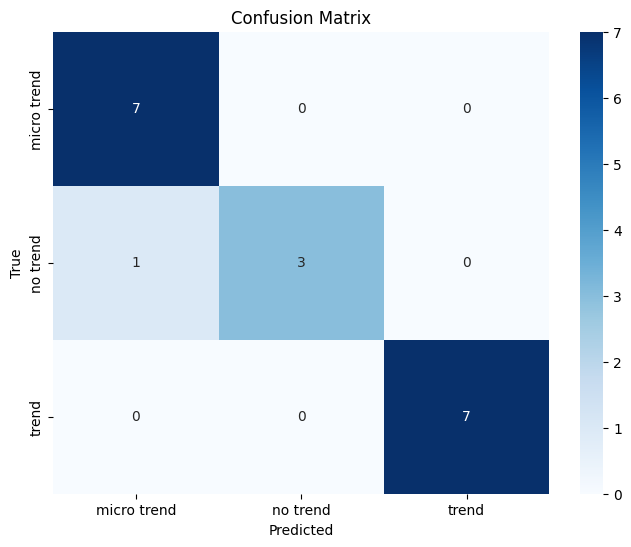

In [485]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with the highest probability

# Step 2: Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Step 3: Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
# print(len(X_test))